In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import scipy
from skimage.io import imread, imshow
from random import sample
from sklearn.preprocessing import StandardScaler
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
#sample_df = pd.read_csv('sample_labels.csv')
#sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
38579,00010077_000.png,No Finding,0,10077,70,M,PA,2500,2048,0.168,0.168,NaN
49900,00012636_006.png,No Finding,6,12636,34,M,PA,2986,2991,0.143,0.143,NaN
110597,00030137_003.png,Effusion|Pneumothorax,3,30137,49,F,AP,3056,2544,0.139,0.139,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1409,00007322_019.png,Atelectasis|Infiltration,19,7322,068Y,F,AP,2500,2048,0.171,0.171
2469,00012413_007.png,Mass,7,12413,043Y,F,AP,2500,2048,0.168,0.168
4051,00019961_004.png,Infiltration,4,19961,063Y,M,PA,2786,2847,0.143,0.143


In [4]:
print(all_xray_df.shape)
print(sample_df.shape)


(112120, 12)
(5606, 11)


### EDA 1, let's find the patient demographic data such as gender, age, patient position etc


Text(0.5, 1.0, 'Gender distribution of total patients')

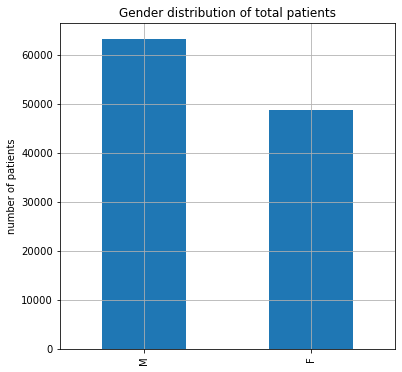

In [7]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.grid('on')
plt.ylabel('number of patients')
plt.title('Gender distribution of total patients')

In [8]:
all_xray_df['Patient Gender'].value_counts()/len(all_xray_df)

M    0.56493
F    0.43507
Name: Patient Gender, dtype: float64

Text(0.5, 1.0, 'Age distribution of total patients')

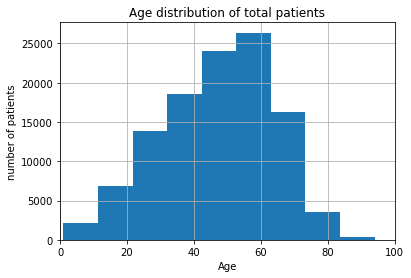

In [9]:
plt.hist(all_xray_df['Patient Age'],bins=40)
plt.grid('on')
plt.xlim([0,100])
plt.xlabel('Age')
plt.ylabel('number of patients')
plt.title('Age distribution of total patients')

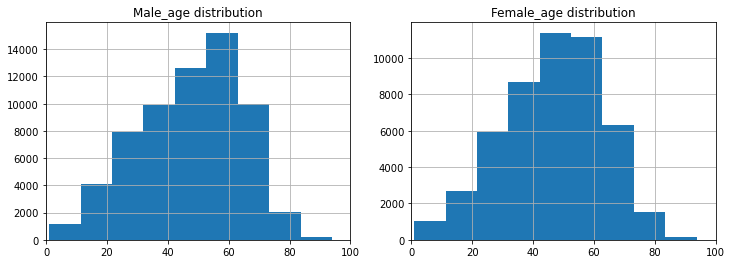

In [10]:
figure=plt.subplots(figsize=(12,4))
plt.subplot(121)
plt.hist(all_xray_df[all_xray_df['Patient Gender']=='M']['Patient Age'],bins=40)
plt.grid('on')
plt.title('Male_age distribution')
plt.xlim([0,100])
plt.subplot(122)
plt.hist(all_xray_df[all_xray_df['Patient Gender']=='F']['Patient Age'],bins=40)
plt.grid('on')
plt.title('Female_age distribution')
plt.xlim([0,100])
plt.show()

From above, the number of the total cases in full NIH dataset is 112120, there were around 56.5% male patients and around 43.5% female patients. From age distribution, the patients' age range from 0 to above 90 years old, the case steadily increases from 0 to the peak region (50~60), then decreases again, there is no significant difference between male patients' age distribution and female patients' age distribution, the slightly difference is that male patients' peak ages are close to 60 years old but female patients' peak ages are close to 50 years old. 

### EDA 2, Let's see the view position from x-ray image

Text(0.5, 0, 'number of total patients')

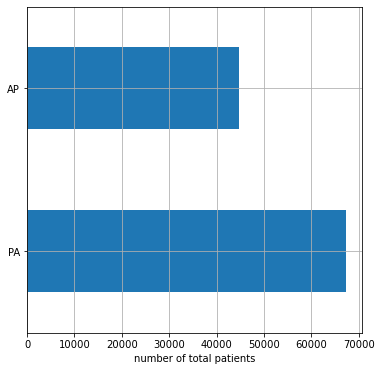

In [10]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='barh')
plt.grid('on')
plt.xlabel('number of total patients')

In [12]:
all_xray_df['View Position'].value_counts()/len(all_xray_df)

PA    0.600339
AP    0.399661
Name: View Position, dtype: float64

#### we could see that there is around 60% PA view position, and 40% AP view position. All these will be considered in the later training dataset since training dataset will use equal rule. Validation set may follow natural rule (realistic) or 80-20 rule.

### EDA 3, Let's find the number of cases with/without pneumonia

First, I will split the finding labels into different disease categories, then I will find the numbers with/without pneumonia.

In [11]:
labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
print(f'Labels ({len(labels)}): {labels}')
for label in labels:
    if len(label)>0:
        all_xray_df[label]=all_xray_df['Finding Labels'].map(lambda x: 1.0 if label in x else 0)
        

all_xray_df.sample(3)        
        

Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
97252,00025656_001.png,Infiltration,1,25656,62,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
92038,00022974_000.png,No Finding,0,22974,51,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2669,00000707_004.png,Atelectasis,4,707,45,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
number_with_pneumonia = len(all_xray_df[all_xray_df['Pneumonia']==1.0])
number_without_pneumonia = len(all_xray_df[all_xray_df['Pneumonia']==0.0])
print('number of pneumonia cases {}, percentage {} '.format(number_with_pneumonia,number_with_pneumonia/len(all_xray_df)))
print('number of no pneumonia cases{}, percentage {} '.format(number_without_pneumonia,number_without_pneumonia/len(all_xray_df)))

number of pneumonia cases 1431, percentage 0.012763110952550838 
number of no pneumonia cases110689, percentage 0.9872368890474491 


#### From above, it was clear that the pneumonia cases were only 1.28% (1431) in X-ray imaging. 

### EDA 4, Let's see the distribution of other diseases that are combined with pneumonia

First, let's see number of all the diseases using bar plot

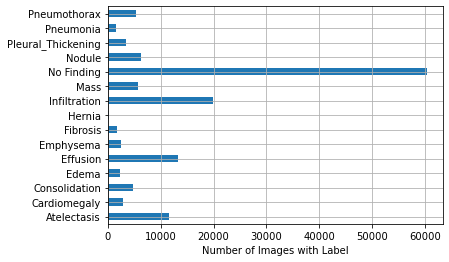

In [15]:
ax = all_xray_df[labels].sum().plot(kind='barh')
ax.set(xlabel='Number of Images with Label')
plt.grid('on')

From plot, the largest number is from no finding, which has no meaning here, we ignore this one. There is total 13 other diseases, and it has a lot of combinations with pneumonia, so here I will just show the first 30 most-happened combinations. 

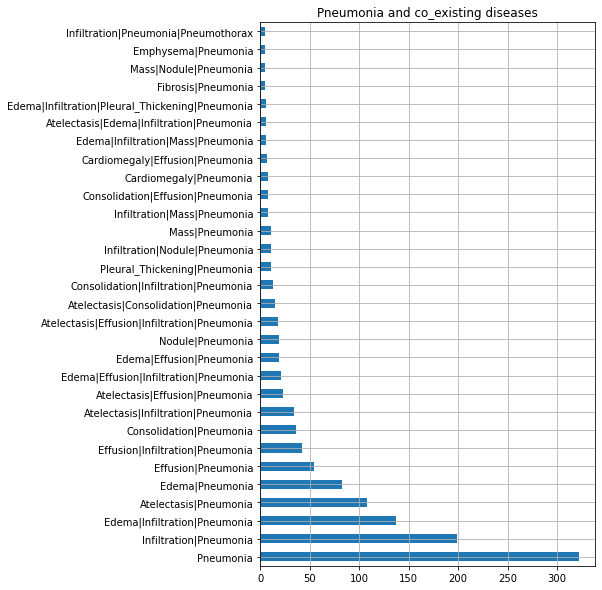

In [17]:
plt.figure(figsize=(6,10))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='barh')
plt.grid('on')
plt.title('Pneumonia and co_existing diseases')
plt.show()

#### It looks that Pneumonia occurs along for the most cases, and its most-common comorbidities are Infiltration, Edema/Infiltration, and Atelectasis and so on.

#### Let's see the age and gender distribution for patients with pneumonia

Text(0.5, 1.0, 'Age distribution of Pneumonia patients')

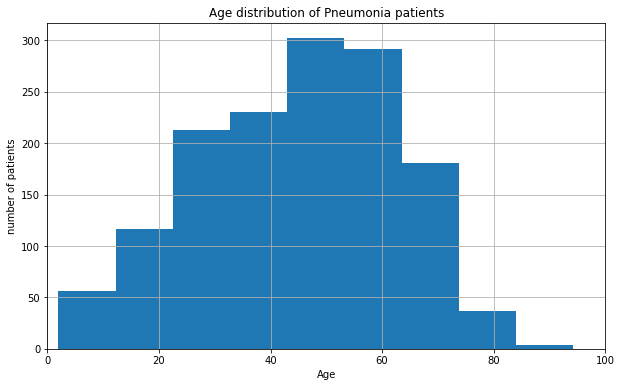

In [19]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1.0]['Patient Age'],bins=40)
plt.xlim([0,100])
plt.grid('on')
plt.xlabel('Age')
plt.ylabel('number of patients')
plt.title('Age distribution of Pneumonia patients')

Text(0.5, 1.0, 'Gender distribution of Pneumonia patients')

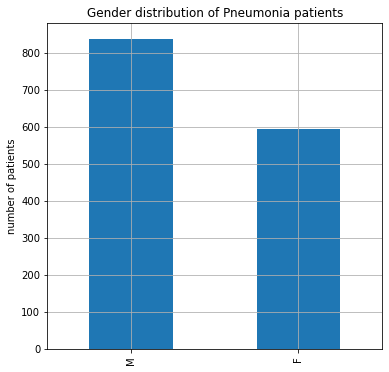

In [20]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1.0]['Patient Gender'].value_counts().plot(kind='bar')
plt.grid('on')
plt.ylabel('number of patients')
plt.title('Gender distribution of Pneumonia patients')

In [19]:
all_xray_df[all_xray_df.Pneumonia==1.0]['Patient Gender'].value_counts()/len(all_xray_df[all_xray_df.Pneumonia==1.0])

M    0.585604
F    0.414396
Name: Patient Gender, dtype: float64

In [20]:
pne = all_xray_df['Pneumonia'].values
pne_inds = np.where(~np.isnan(pne))
ages = all_xray_df.iloc[pne_inds]['Patient Age']
pne=pne[pne_inds]
scipy.stats.pearsonr(pne,ages)
##using all_xray_df['Pneumonia'].corr(all_xray_df['Patient Age'])

(-0.013329295550928684, 8.067938685451712e-06)

The Pearson's correlation coefficient is -0.013, which means that the Pneumonia and age are not significantly correlated.

In [21]:
scipy.stats.ttest_ind(all_xray_df[all_xray_df['Patient Gender']== 'F']['Pneumonia'],all_xray_df[all_xray_df['Patient Gender']== 'M']['Pneumonia'],nan_policy='omit')

Ttest_indResult(statistic=-1.5876642536480141, pvalue=0.11236510019247703)

Looks like the distribution of age and gender for patients with pneumonia are similar to the age and gender distribution for all data. There is no statistivally significant different between Pneumonia with gender. 

### EDA 5, Number of disease per patient

In [22]:
print('Patient number: ',len(np.unique(all_xray_df['Patient ID'])))
print('Total cases :  ',len(all_xray_df))

Patient number:  30805
Total cases :   112120


In [23]:
temp_label=['Patient ID','Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
data=all_xray_df[temp_label];

temp=data.groupby('Patient ID', axis=0).agg(np.sum)
for label in temp_label[1:]:
    temp[label]=(temp[label]>0.0).replace(True,1.0).replace(False,0.0)
temp['number of disease']=temp[temp_label[1:]].sum(axis=1,numeric_only=True)

temp['number of disease']


Patient ID
1        3.0
2        0.0
3        2.0
4        2.0
5        2.0
        ... 
30801    2.0
30802    0.0
30803    0.0
30804    0.0
30805    0.0
Name: number of disease, Length: 30805, dtype: float64

Text(0, 0.5, 'number of patient ID')

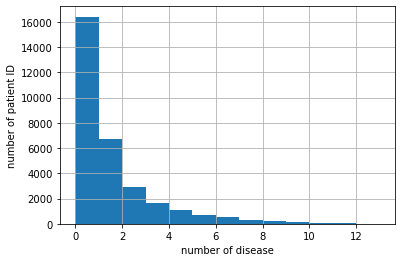

In [25]:
plt.hist(temp['number of disease'],bins=13)
plt.grid('on', which='both')
plt.xlabel('number of disease')
plt.ylabel('number of patient ID')

In [26]:
temp['number of disease'].value_counts()

0.0     16403
1.0      6742
2.0      2908
3.0      1638
4.0      1087
5.0       707
6.0       518
7.0       335
8.0       205
9.0       139
10.0       84
11.0       28
12.0        7
13.0        4
Name: number of disease, dtype: int64

#### From the above, there are total 30805 patient IDs, 16403 IDs have no disease, 6742 IDs have 1 disease, 2908 IDs have 2 diseases, 4 patients have maximum 13 diseases.  

### EDA 6, Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distribution across diseases

In this pixel-assessment, we will use the sample_df.csv.
#### it Looks there are 5606 images in the sample.csv, I will choose some of the images with different/no diseases for analysis. 

In [27]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [58]:
ind=sample_df[sample_df['Finding Labels']=='No Finding'].index.to_list()

In [59]:
img0=[]
for item in sample(ind,9):
    img_path=glob("/data/*/images/{}".format(sample_df['Image Index'][item]))
    img0.append(imread(img_path[0]))

    

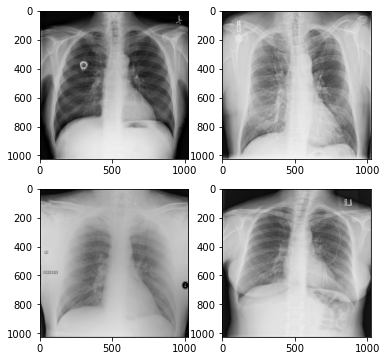

In [62]:
figure=plt.subplots(figsize=(6,6))
for i in range(4):
#    img0_mask=(img0[i]>thresh)*255
    plt.subplot(2,2,i+1)
    plt.imshow(img0[i],cmap='gray', vmin=0, vmax=255)

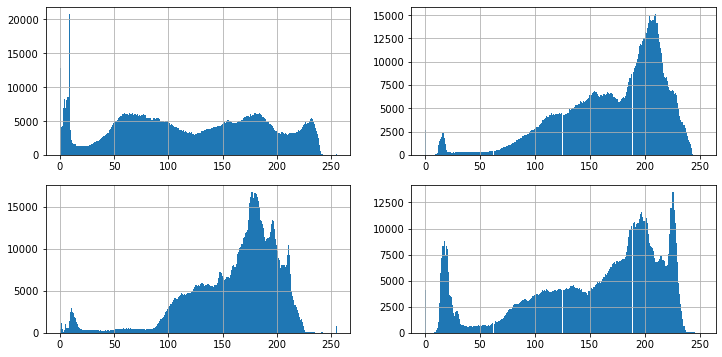

In [63]:
figure=plt.subplots(figsize=(12,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(img0[i].ravel(),bins=256);
    plt.grid('on')
#    plt.ylim([0,40000])
plt.show()

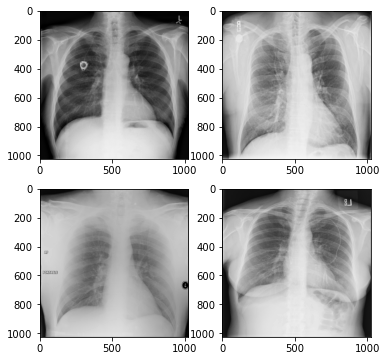

In [64]:
### let's see the normalized plots
figure=plt.subplots(figsize=(6,6))
img0_norm=[]
for i in range(4):
    new_img0=img0[i].copy()
    tmp=(new_img0 - new_img0.mean())/new_img0.std()
    #    img0_mask=(img0[i]>thresh)*255
    img0_norm.extend(tmp)
    plt.subplot(2,2,i+1)
    plt.imshow(tmp, cmap='gray')

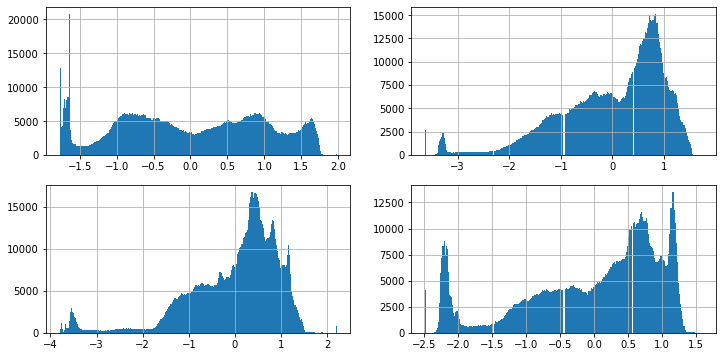

In [65]:
figure=plt.subplots(figsize=(12,6))
for i in range(4):
    new_img0=img0[i].copy()
    tmp=(new_img0 - new_img0.mean())/new_img0.std()
    plt.subplot(2,2,i+1)
    plt.hist(tmp.ravel(),bins=256);
    plt.grid('on')
#    plt.ylim([0,40000])
plt.show()

From above plots, the normalization does not change shape but makes the mean locating at 0. These random plots are all from healthy IDs, it is clear that the intensity profiles are still quite different. Let's do background segmentation using different thresh.

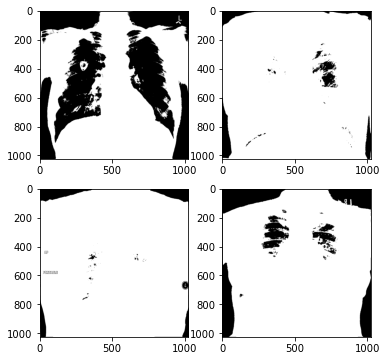

In [66]:
thresh=90
#img0_bin=(img0>thresh)*255
figure=plt.subplots(figsize=(6,6))
for i in range(4):
    img0_mask=(img0[i]>thresh)*255
    plt.subplot(2,2,i+1)
    plt.imshow(img0_mask,cmap='gray')

In [67]:
img0_intensities=[]
thresh=90
for item in sample(ind,7):
    img_path=glob("/data/*/images/{}".format(sample_df['Image Index'][item]))
    img0= imread(img_path[0])
    img0_mask=(img0 > thresh)
    img0_intensities.extend(img0[img0_mask].tolist())
    

(90.0, 250.0)

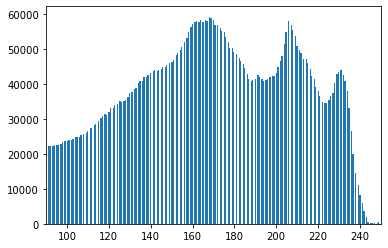

In [68]:
x =plt.hist(img0_intensities,bins=256)
plt.xlim([90,250])
#plt.ylim([0,400000])

#### Let's see the distribution with diseases. First only Pneumonia

In [69]:
ind1=sample_df[sample_df['Finding Labels']=='Pneumonia'].index.to_list()
        
img1=[]
for item in ind1[:-1]:
    img_path1=glob("/data/*/images/{}".format(sample_df['Image Index'][item]))
    img1.append(imread(img_path1[0]))
print(len(img1))

ind2=sample_df[sample_df['Finding Labels']=='Infiltration'].index.to_list()
img2=[]
for item in ind2[:-1]:
    img_path1=glob("/data/*/images/{}".format(sample_df['Image Index'][item]))
    img2.append(imread(img_path1[0]))
print(len(img2))

ind3=sample_df[sample_df['Finding Labels']=='Infiltration|Pneumonia'].index.to_list()
img3=[]
for item in ind3[:-1]:
    img_path1=glob("/data/*/images/{}".format(sample_df['Image Index'][item]))
    img3.append(imread(img_path1[0]))
print(len(img3))

13
502
7


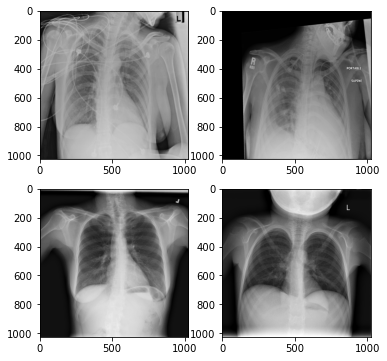

In [70]:
#img0_bin=(img0>thresh)*255
figure=plt.subplots(figsize=(6,6))
for i in range(4):
#    img1_mask=(img1[i]>thresh)*255
    plt.subplot(2,2,i+1)
    plt.imshow(img1[i],cmap='gray', vmin=0, vmax=255)

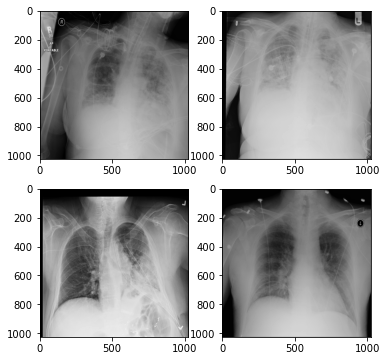

In [71]:
#img0_bin=(img0>thresh)*255
figure=plt.subplots(figsize=(6,6))
for i in range(4):
#    img1_mask=(img1[i]>thresh)*255
    plt.subplot(2,2,i+1)
    plt.imshow(img2[i],cmap='gray', vmin=0, vmax=255)

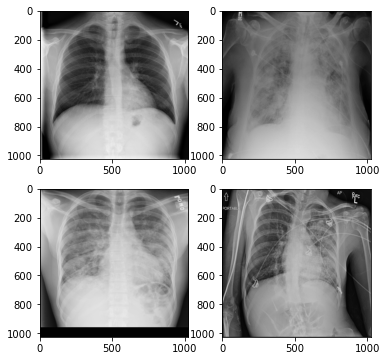

In [72]:
#img0_bin=(img0>thresh)*255
figure=plt.subplots(figsize=(6,6))
for i in range(4):
#    img1_mask=(img1[i]>thresh)*255
    plt.subplot(2,2,i+1)
    plt.imshow(img3[i],cmap='gray', vmin=0, vmax=255)

In [73]:
img1_intensities=[]
thresh=90
for item in sample(ind1,7):
    img_path=glob("/data/*/images/{}".format(sample_df['Image Index'][item]))
    img1= imread(img_path[0])
    img1_mask=(img1 > thresh)
    img1_intensities.extend(img1[img1_mask].tolist())

img2_intensities=[]
thresh=90
for item in sample(ind2,7):
    img_path=glob("/data/*/images/{}".format(sample_df['Image Index'][item]))
    img2= imread(img_path[0])
    img2_mask=(img2 > thresh)
    img2_intensities.extend(img2[img2_mask].tolist())    

img3_intensities=[]
thresh=90
for item in ind3:
    img_path=glob("/data/*/images/{}".format(sample_df['Image Index'][item]))
    img3= imread(img_path[0])
    img3_mask=(img3 > thresh)
    img3_intensities.extend(img3[img3_mask].tolist())        

Text(0.5, 1.0, 'Infiltration and Pneumonia')

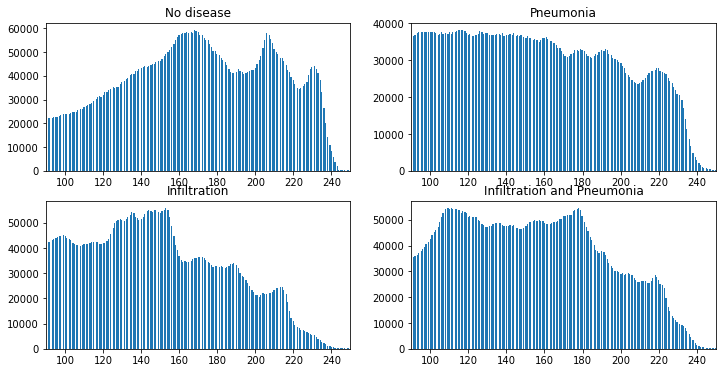

In [75]:
figure=plt.subplots(figsize=(12,6))
plt.subplot(221)
x =plt.hist(img0_intensities,bins=256)
plt.xlim([90,250])
plt.title('No disease')
#plt.ylim([0,400000])
plt.subplot(222)
x =plt.hist(img1_intensities,bins=256)
plt.xlim([90,250])
plt.title('Pneumonia')
#plt.ylim([0,400000])
plt.subplot(223)
x =plt.hist(img2_intensities,bins=256)
plt.xlim([90,250])
plt.title('Infiltration')
#plt.ylim([0,400000])
plt.subplot(224)
x =plt.hist(img3_intensities,bins=256)
plt.xlim([90,250])
plt.title('Infiltration and Pneumonia')
#plt.ylim([0,400000])

From pixel-assessment, we investigates the histogram of intensity values with different diseases states. Ostu method has been used here to obtain the intensity distribution across disease. Here thresh=90 seems relative good for background segmentation. The intensity vs. no disease seems quite different compared to the intensity vs. disease. But for intensity vs.Pneumonia does not show much difference for others (the intensity vs. Infiltration, and the intensity vs. Infiltration/Pneumonia), this makes the decision very complicated. 